In [25]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools
%matplotlib inline

In [26]:
def create_toy_data(func, sample_size, std):
    x = np.linspace(0, 1, sample_size)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

def func(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(func, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = func(x_test)

(a) Plot the graph with given code, the result should be same as this.
![](originalData.png)
`x_train` and `y_train` are the datas you need to create, `sample_size` is 10 and `std` is 0.25. 

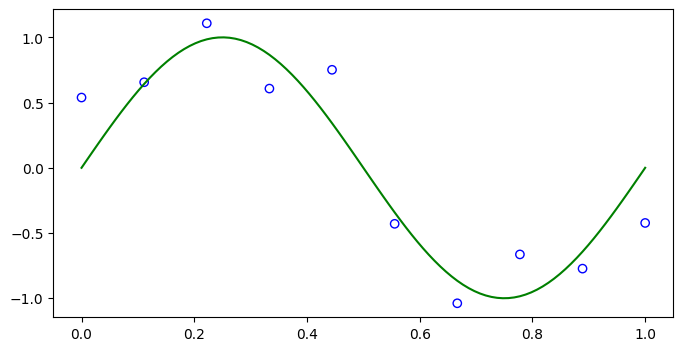

In [27]:
# Write you codes here.
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(x_test, y_test, color='g')
plt.scatter(x_train, y_train, color='b', marker='o', facecolor='none')

(b) On the basis of the results, you should try $0^{th}$ order polynomial, $1^{st}$ order polynomial, $3^{rd}$ order polynomial and some other order polynomial, show the results include fitting and over-fitting.
![](fitting.png)

In [28]:
class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()
    
class Regression(object):
    """
    Base class for regressors
    """
    pass
    
class LinearRegression(Regression):
    """
    Linear regression model
    y = X @ w
    t ~ N(t|X @ w, var)
    """

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        perform least squares fitting

        Parameters
        ----------
        X : (N, D) np.ndarray
            training independent variable
        t : (N,) np.ndarray
            training dependent variable
        """
        self.w = np.linalg.pinv(X) @ t
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X:np.ndarray, return_std:bool=False):
        """
        make prediction given input

        Parameters
        ----------
        X : (N, D) np.ndarray
            samples to predict their output
        return_std : bool, optional
            returns standard deviation of each predition if True

        Returns
        -------
        y : (N,) np.ndarray
            prediction of each sample
        y_std : (N,) np.ndarray
            standard deviation of each predition
        """
        y = X @ self.w
        if return_std:
            y_std = np.sqrt(self.var) + np.zeros_like(y)
            return y, y_std
        return y

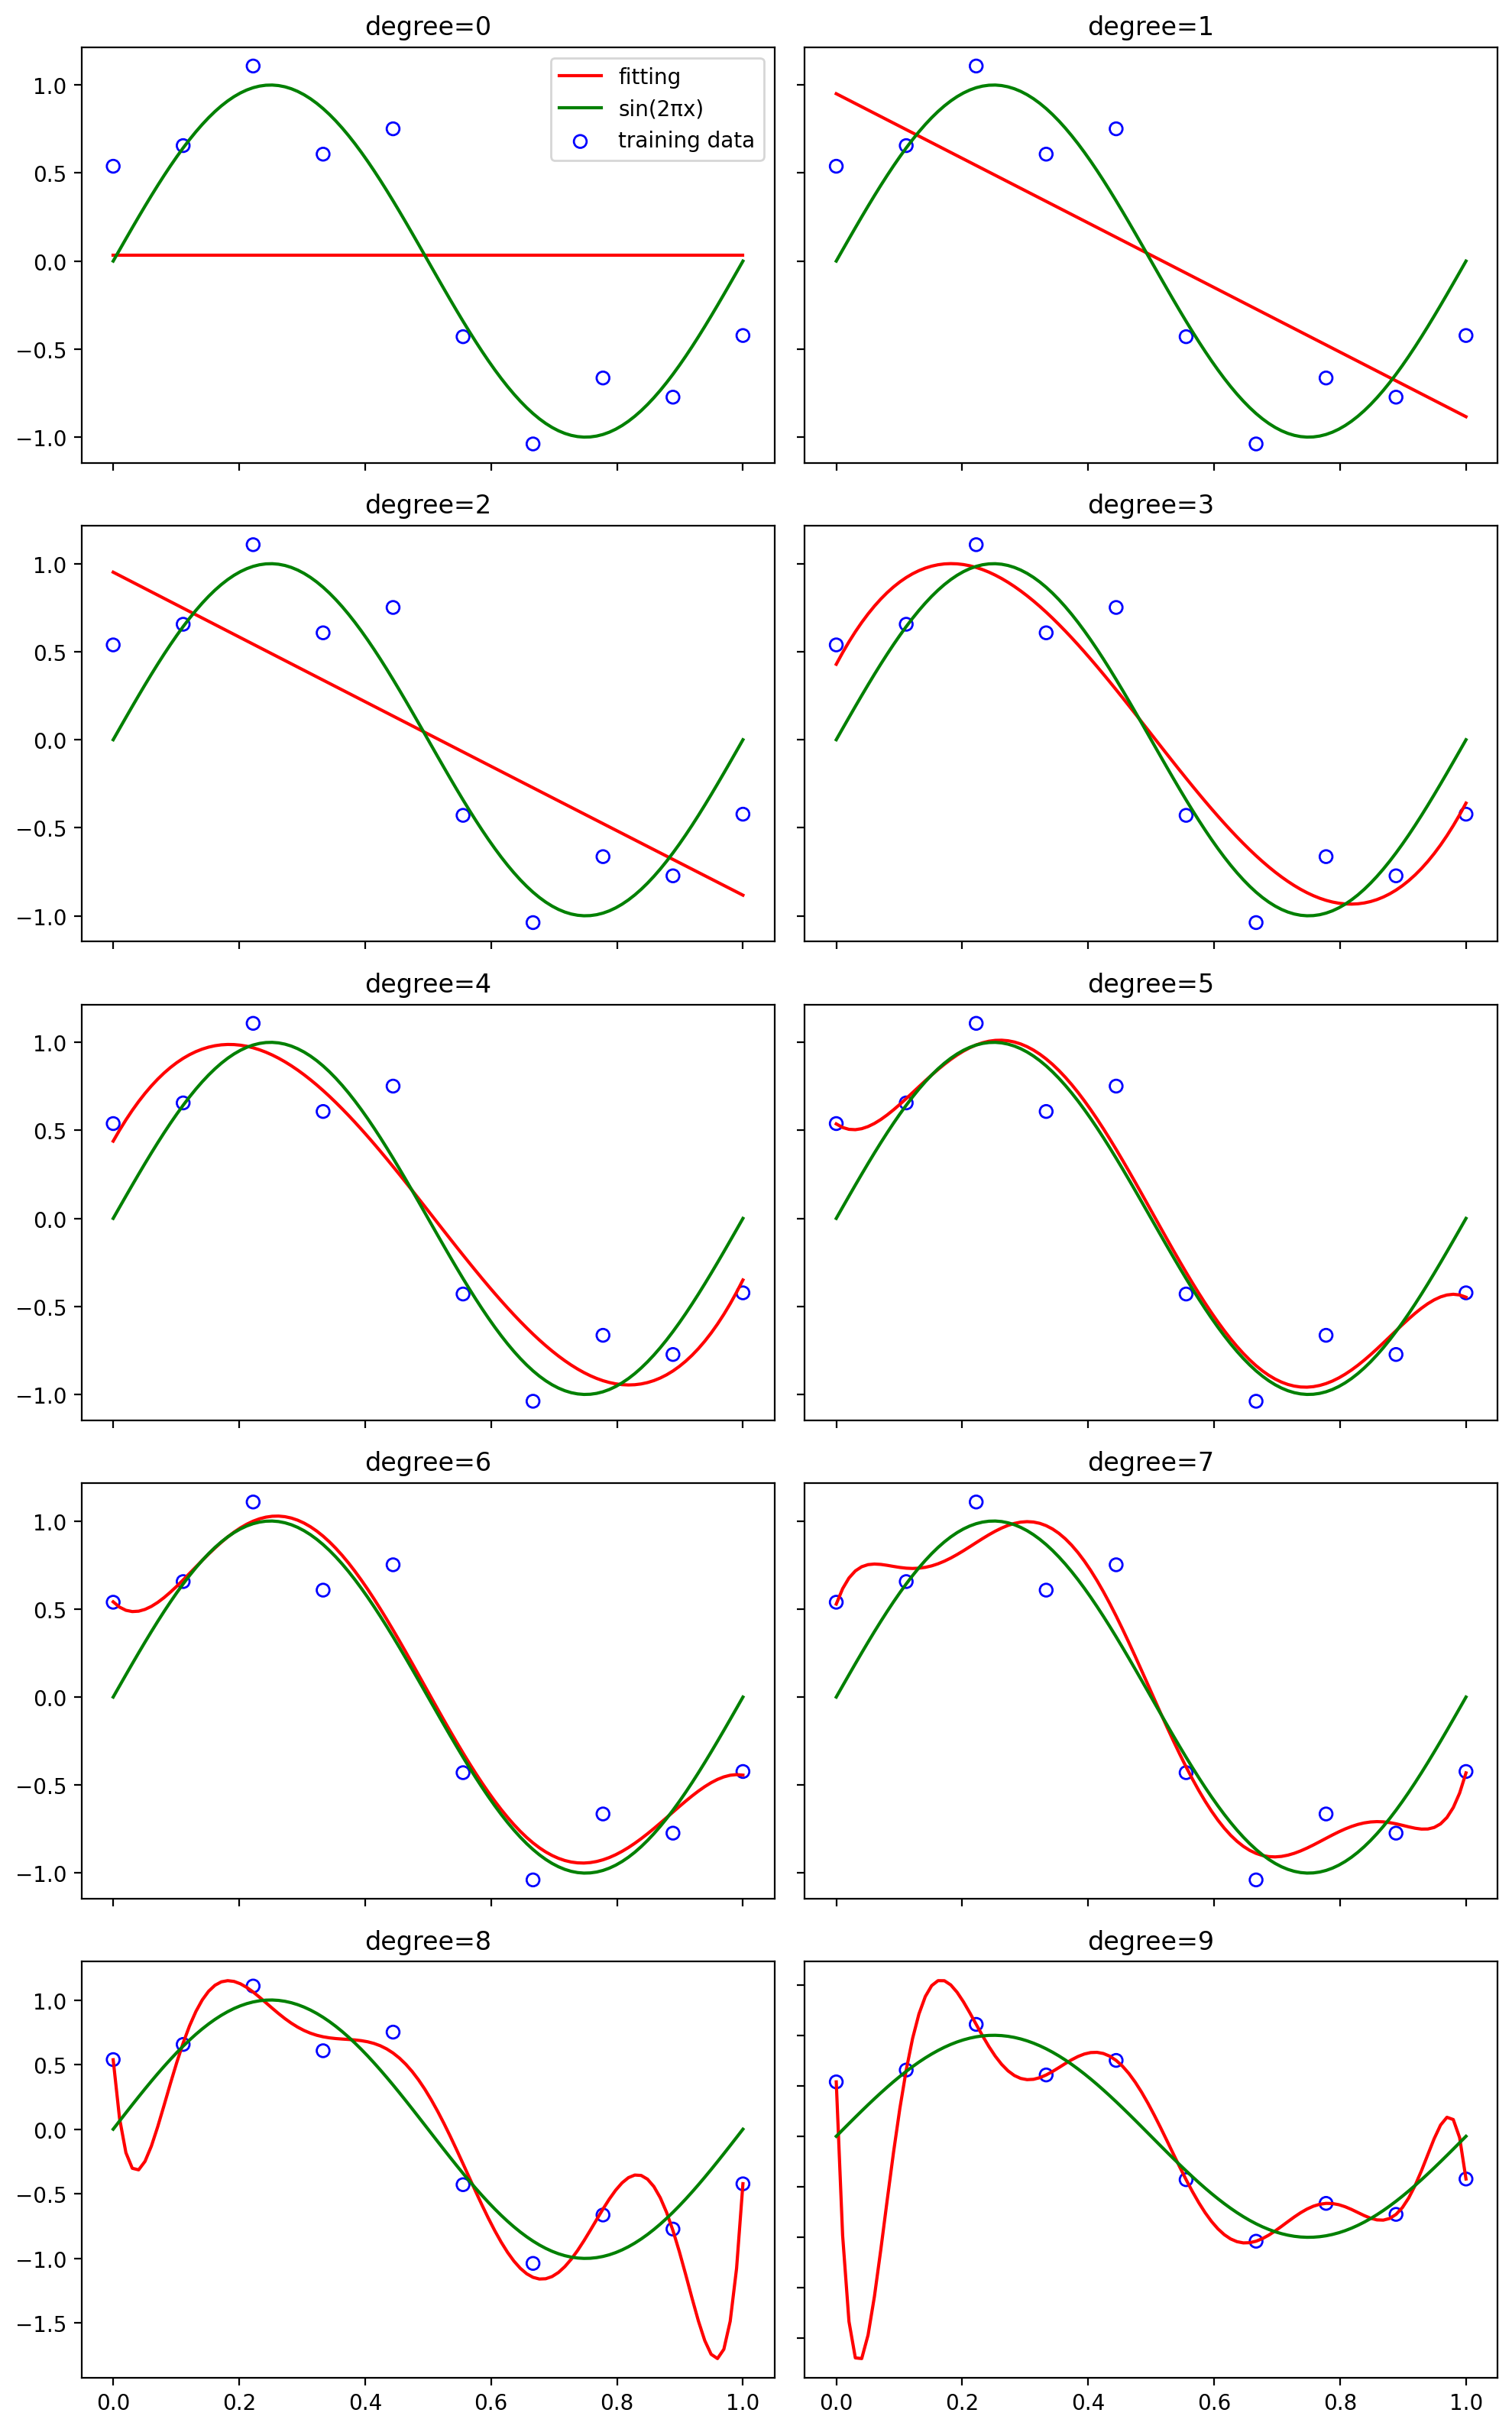

In [29]:
rows, cols = 5, 2

fig, axes = plt.subplots(rows, cols, figsize=(10, 16), dpi=200)
for degree, ax in enumerate(axes.flat):

    lr = LinearRegression()
    lr.fit(PolynomialFeature(degree).transform(x_train), y_train)
    y_pred = lr.predict(PolynomialFeature(degree).transform(x_test))

    ax.plot(x_test, y_pred, color='r', label='fitting')
    ax.plot(x_test, y_test, color='g', label='sin(2πx)')
    ax.scatter(x_train, y_train, color='b', marker='o', facecolor='none', label='training data')
    ax.set_title(f"degree={degree}")

    ax.label_outer() # 隐藏legend

legend_ax = axes[0, 0]
legend_ax.legend(loc="upper right")
    

plt.tight_layout()
plt.show()


(c) Plot the graph of the root-mean-square error.
![](rmse.png)

In [30]:
def rmse(a, b):
    # Complete this function
    return np.sqrt(np.mean((a - b) ** 2))

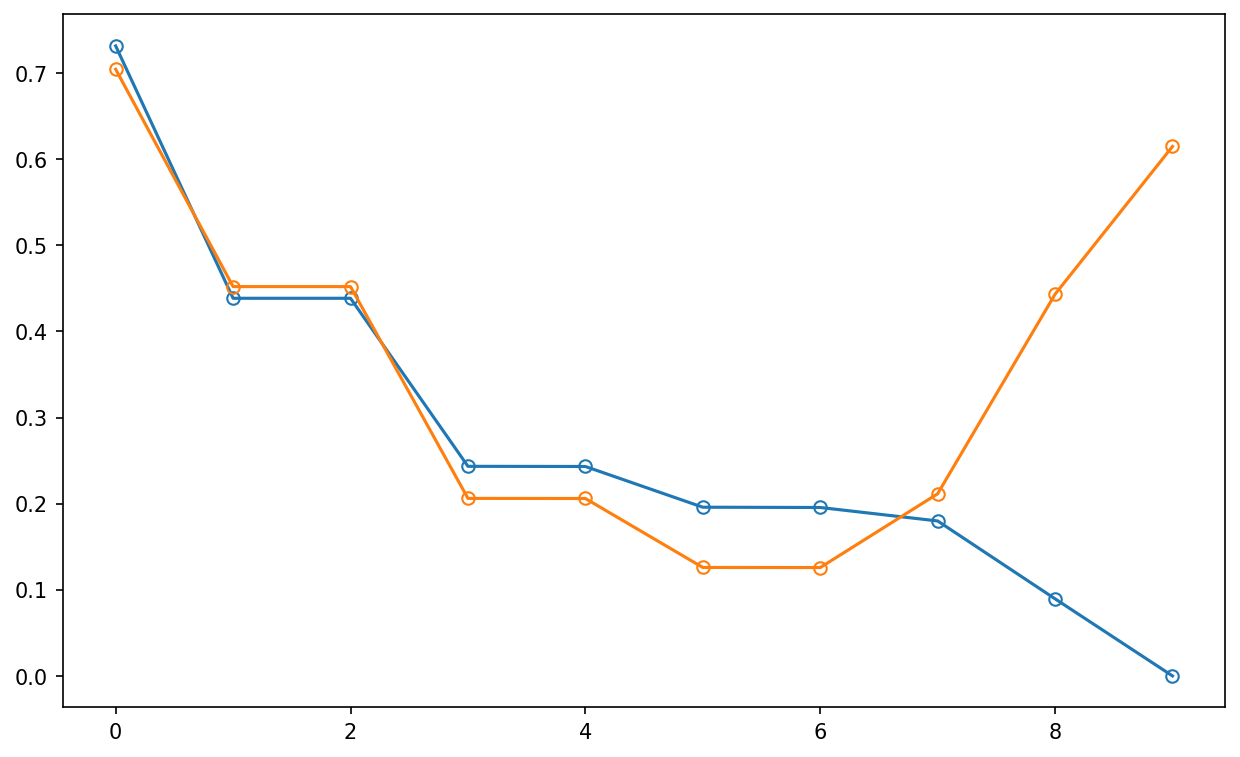

In [31]:
# Write your codes here.
training_errors = []
test_errors = []

for degree in range(10):
    lr = LinearRegression()
    x_train_pf = PolynomialFeature(degree).transform(x_train)
    x_test_pf = PolynomialFeature(degree).transform(x_test)

    lr.fit(x_train_pf, y_train)
    y_pred = lr.predict(x_test_pf)

    training_errors.append(rmse(y_train, lr.predict(x_train_pf)))
    test_errors.append(rmse(y_test, lr.predict(x_test_pf)))


plt.figure(figsize=(10, 6), dpi=150)
plt.plot(range(10), training_errors, marker='o', markerfacecolor='none')
plt.plot(range(10), test_errors, marker='o', markerfacecolor='none')

(d) Plot the graph of the predictive distribution resulting from a Bayesian treatment of polynomial curve fitting using an M=9 polynomial, with the fixed parameters $\alpha=5\times 10^{-3}$ and $\beta=11.1$(corresponding to the known noise variance).
![](bayesianRegression.png)

In [32]:
class BayesianRegression(Regression):
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

        self.w_sample = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            self.w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ self.w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

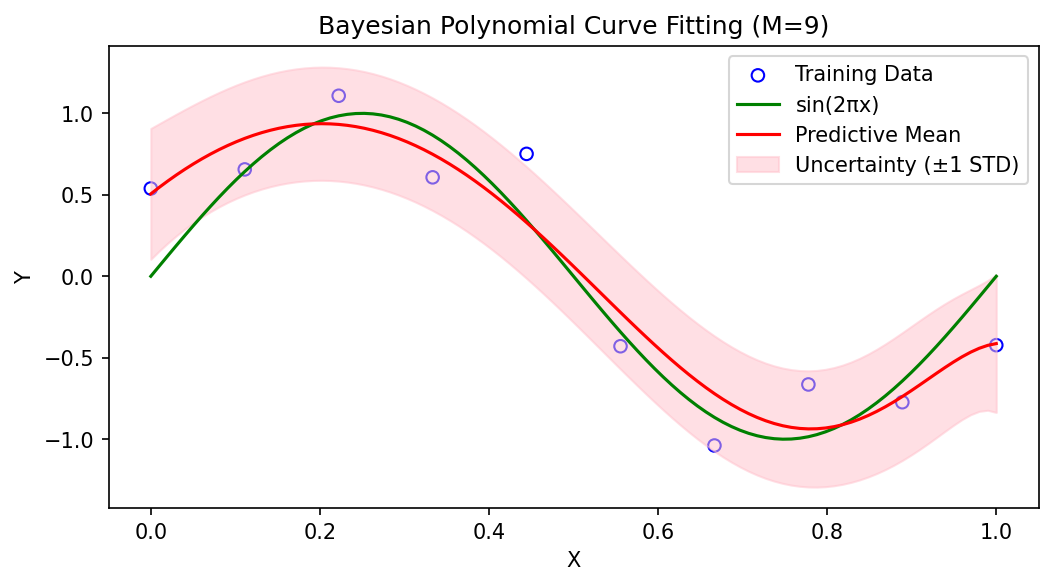

In [33]:
# Write your codes here.

# Create a grid of input values for prediction
x_grid = np.linspace(0, 1, 100)  # Adjust the range as needed

# Instantiate your Bayesian regression model with the fixed parameters
bayesian_model = BayesianRegression(alpha=5e-3, beta=11.1)
bayesian_model.fit(PolynomialFeature(degree=9).transform(x_train), y_train)
# Make predictions on the grid
mean, std = bayesian_model.predict(PolynomialFeature(degree=9).transform(x_test), return_std=True)

# Plot the predictive distribution
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(x_train, y_train, color='blue', marker='o', label="Training Data", facecolor='none')
plt.plot(x_test, y_test, color='green', label='sin(2πx)')
plt.plot(x_test, mean, color='red', label="Predictive Mean")
plt.fill_between(x_grid, mean - std, mean + std, color='pink', alpha=0.5, label="Uncertainty (±1 STD)")
plt.title("Bayesian Polynomial Curve Fitting (M=9)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

(e) Change the $sample\_size$ to 2, 3 or 10 times than before, explain the change of $M$.

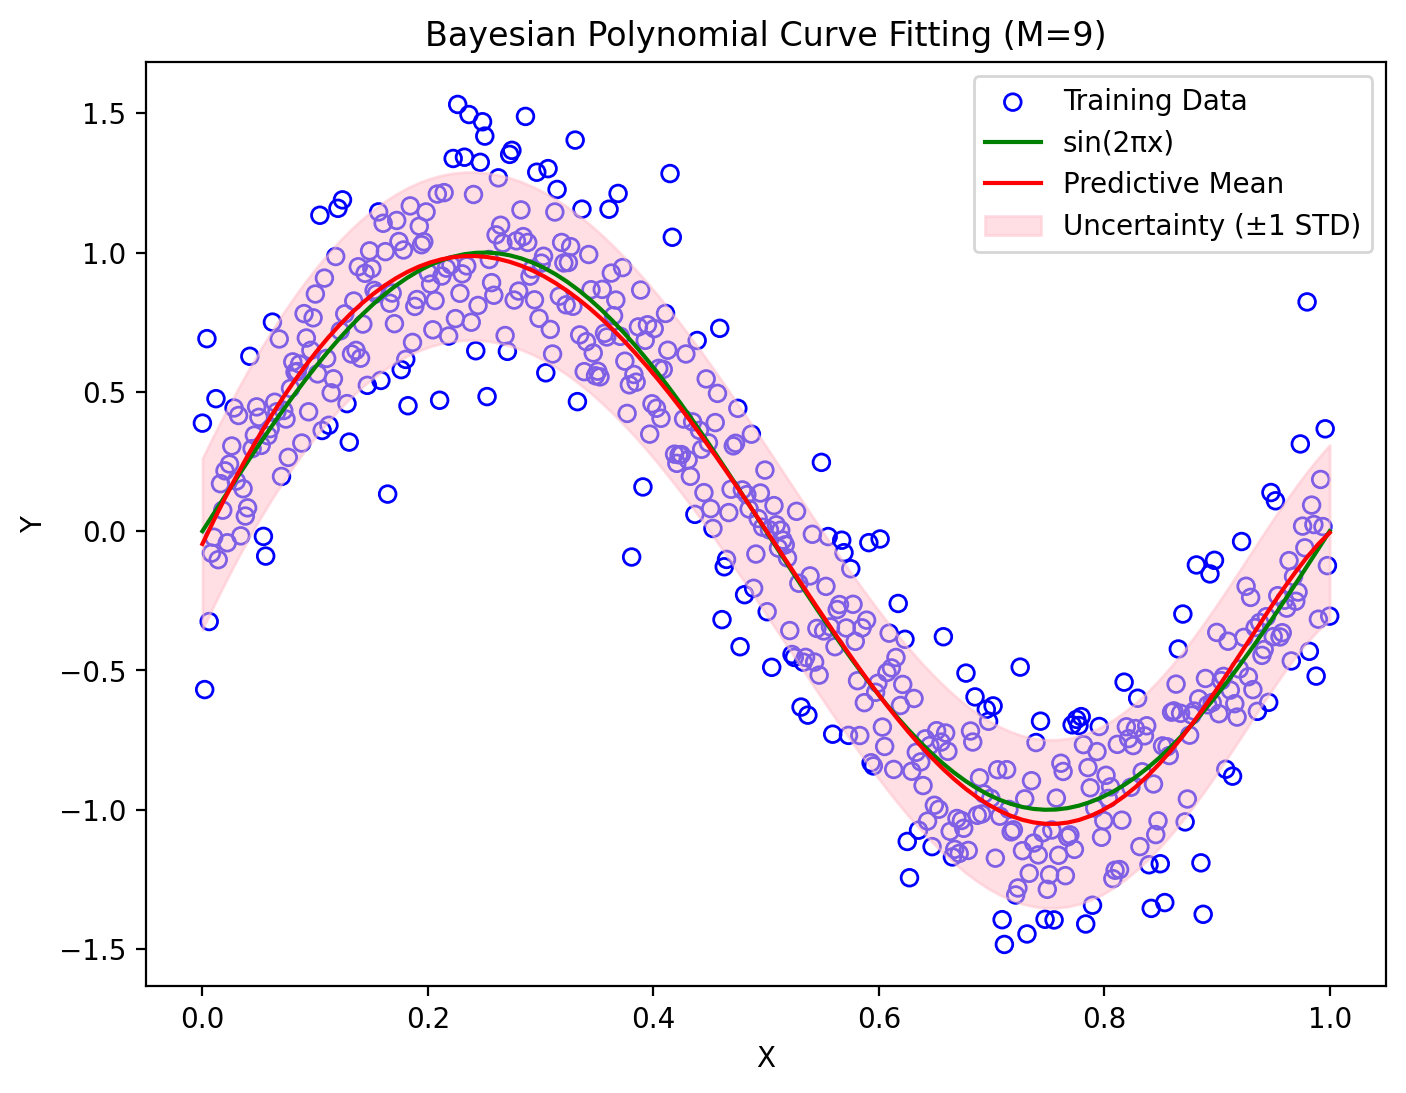

In [35]:
# Write your codes here.
# Create a grid of input values for prediction
x_grid = np.linspace(0, 1, 100)  # Adjust the range as needed
M = 10
# Instantiate your Bayesian regression model with the fixed parameters
bayesian_model = BayesianRegression(alpha=5e-3, beta=11.1)

# 修改x_train, y_train
x_train, y_train = create_toy_data(func, 500, 0.25)
bayesian_model.fit(PolynomialFeature(degree=M).transform(x_train), y_train)
# Make predictions on the grid
mean, std = bayesian_model.predict(X=PolynomialFeature(degree=M).transform(x_test), return_std=True)

# Plot the predictive distribution
plt.figure(figsize=(8, 6), dpi=200)
plt.scatter(x_train, y_train, color='blue', marker='o', label="Training Data", facecolor='none')
plt.plot(x_test, y_test, color='green', label='sin(2πx)')
plt.plot(x_test, mean, color='red', label="Predictive Mean")
plt.fill_between(x_grid, mean - std, mean + std, color='pink', alpha=0.5, label="Uncertainty (±1 STD)")
plt.title("Bayesian Polynomial Curve Fitting (M=9)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()
